### Instaladores

In [1]:
# ------------------------- #
# Importación de librerías  #
# ------------------------- #

# Librerías estándar para análisis de datos y cálculos matemáticos
import numpy as np
import pandas as pd
import math
import random

# Librerías para bases de datos
import pyodbc
import sqlite3

# Visualización
import seaborn as sns

# Machine Learning y modelado
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_predict

# Estadísticas y pruebas de hipótesis
from scipy.stats import (
    rv_discrete, t, binom, chi2, f, 
    ttest_ind
)
from sklearn.utils import resample

# ------------------------- #
# Importación de módulos    #
# ------------------------- #

# Modulo EDA
import importlib
import funciones_eda
importlib.reload(funciones_eda)
from funciones_eda import *

# Módulo de funciones personalizadas
import funciones_m
importlib.reload(funciones_m)
from funciones_m import *

# Módulo de distribución
import funciones_distribucion
importlib.reload(funciones_distribucion)
from funciones_distribucion import *

# Módulo de pruebas significativas
import funciones_pruebas_significativas
importlib.reload(funciones_pruebas_significativas)
from funciones_pruebas_significativas import *

# Módulo de clostering
import funciones_clostering
importlib.reload(funciones_clostering)
from funciones_clostering import *

import warnings

# Ignorar advertencias de tipo UserWarning
warnings.filterwarnings('ignore', category=UserWarning)

### data set 

In [2]:
url = 'df_ML.csv'
df = pd.read_csv(url, index_col=None)
#df.drop('index', axis=1, inplace=True)

In [3]:
# Definir la variable objetivo y las características
y = df['se_compra']
X = df.drop('se_compra', axis=1)

In [4]:
# Dividir las semanas en entrenamiento y prueba
semana_corte = 24


# datos de entrenamiento 
X_train_ = df[df['Semana'] <= semana_corte].drop(['se_compra','cantidad'], axis=1)
y_train = df[df['Semana'] <= semana_corte]['se_compra']
X_test_ = df[df['Semana'] > semana_corte].drop(['se_compra','cantidad'], axis=1)
y_test = df[df['Semana'] > semana_corte]['se_compra']

# Verificar tamaños
print("Entrenamiento:", X_train_.shape, y_train.shape)
print("Prueba:", X_test_.shape, y_test.shape)


Entrenamiento: (27732, 3) (27732,)
Prueba: (4990, 3) (4990,)


### ESCALAR LOS DATOS

In [5]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train= scaler.fit_transform(X_train_)
X_test = scaler.transform(X_test_)



### analisis mejor modelo 

In [6]:

# Lista de modelos
modelos = {
    "Logistic Regression": LogisticRegression(),
    "XGBClassifier":XGBClassifier(random_state=42, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME', random_state=42),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    #"SVM (Linear Kernel)": SVC(kernel='linear', probability=True),
    #"SVM (RBF Kernel)": SVC(kernel='rbf', probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    #"LightGBM": LGBMClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    #"QDA": QuadraticDiscriminantAnalysis()
}


In [7]:
resultados={}
from sklearn.metrics import log_loss, roc_auc_score, precision_recall_curve, auc
for nombre, modelo in modelos.items():
    #print(f'entrenando modelo {nombre}')
    modelo.fit(X_train, y_train)
    probabilidades=modelo.predict_proba(X_test)[:, 1] 
    resultados[nombre] = probabilidades
    
    logloss = log_loss(y_test, probabilidades)
    roc_auc = roc_auc_score(y_test, probabilidades)
    precision, recall, _ = precision_recall_curve(y_test, probabilidades)
    pr_auc = auc(recall, precision)
    


el código entrena varios modelos de clasificación, predice probabilidades en el conjunto de prueba y evalúa el rendimiento de cada modelo utilizando métricas como Log Loss, AUC-ROC y PR AUC. Esto permite comparar el desempeño de los diferentes modelos para seleccionar el más adecuado 

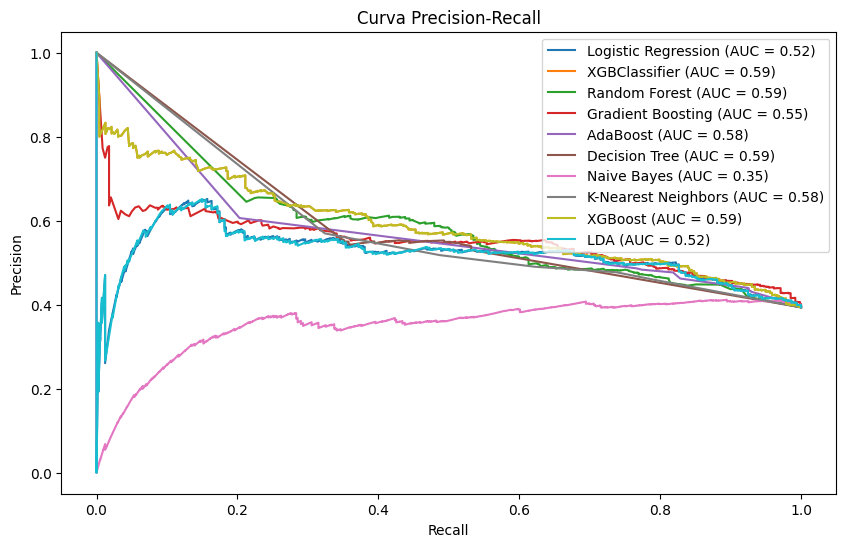

In [8]:

AUC={}
plt.figure(figsize=(10, 6))
for nombre, probabilidades in resultados.items():
    precision, recall, _ = precision_recall_curve(y_test, probabilidades)
    pr_auc = auc(recall, precision)
    
    AUC[nombre]=pr_auc
    
    plt.plot(recall, precision, label=f'{nombre} (AUC = {pr_auc:.2f})')
    
    

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()


In [9]:
df_auc = pd.DataFrame(list(AUC.items()), columns=["Modelo", "AUC"])
df_auc.sort_values(by='AUC',ascending=False)

,Modelo,AUC
2,Random Forest,0.5888
1,XGBClassifier,0.5884
8,XGBoost,0.5884
5,Decision Tree,0.5880
7,K-Nearest Neighbors,0.5812
4,AdaBoost,0.5754
3,Gradient Boosting,0.5487
0,Logistic Regression,0.5185
9,LDA,0.5176
6,Naive Bayes,0.3522


Decision Tree  Es el modelo con el mejor desempeño, aunque su AUC apenas se acerca a 0.6, lo que indica que tiene un rendimiento ligeramente superior al azar.
Esto podría deberse a que el modelo captura bien patrones locales en los datos, pero su falta de generalización podría limitar el rendimiento.

### modelo 

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Crear el modelo de boosting
#model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model = RandomForestClassifier(n_estimators=100, random_state=42)
# Entrenar el modelo
model.fit(X_train, y_train)

# Predicciones probabilísticas (para la clase 1)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Convertir probabilidades a predicciones binarias (umbral 0.5 por defecto)
y_pred = (y_proba >= 0.5).astype(int)

# Evaluación
print("Reporte de Clasificación basado en probabilidades:")
print(classification_report(y_test, y_pred))

# Evaluación adicional: ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")


Reporte de Clasificación basado en probabilidades:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      3025
           1       0.54      0.54      0.54      1965

    accuracy                           0.64      4990
   macro avg       0.62      0.62      0.62      4990
weighted avg       0.64      0.64      0.64      4990

ROC-AUC: 0.6663


se toma el mejor modelo Decision Treeel el cual modelo tiene un desempeño aceptable para la clase mayoritaria, pero es deficiente en la identificación de la clase minoritaria. Con ajustes y técnicas de balanceo, el rendimiento podría mejorar significativamente

el valor ROC-AUC 0.6232 sugiere que el modelo tiene un desempeño moderado y no es excelente en diferenciar entre las clases 0 y 1.

el ROC-AUC mide qué tan bien el modelo puede distinguir entre las clases positivas y negativas. el cual no se ve directamente afectada por el desbalance, ya que se enfoca en las tasas de verdaderos positivos (TPR) y falsos positivos (FPR) en lugar de las cantidades absolutas.

### cross validation 

Se busca la mejor configuración de hiperparámetros para el modelo mediante GridSearchCV, Este enfoque evita el sobreajuste, ya que las probabilidades se calculan en subconjuntos separados del conjunto de entrenamiento.

In [11]:


grid = {
    'criterion': ['gini', 'entropy'],  # Función para medir la calidad de los splits
    'splitter': ['best', 'random'],  # Estrategia para dividir en nodos
    'max_depth': [3, 5, 10, None],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Muestras mínimas necesarias para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 8],  # Muestras mínimas en un nodo hoja
    'max_features': [None, 'sqrt', 'log2'],  # Máximo número de características a considerar para un split
    'class_weight': [None, 'balanced'],  # Pesos para las clases (especialmente útil para datos desbalanceados)
    'random_state': [42]  # Para reproducibilidad
}


# Crear el modelo base
modelo = DecisionTreeClassifier(random_state=42)

# Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=modelo, param_grid=grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10], 'random_state': [42],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=1)

In [12]:
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}


In [13]:
from sklearn.metrics import confusion_matrix

y_proba_cv = cross_val_predict(
    best_model, X_train, y_train, cv=5, method="predict_proba"
)[:, 1]  # Probabilidades para la clase positiva

# Métricas de rendimiento
roc_auc = roc_auc_score(y_train, y_proba_cv)
precision, recall, _ = precision_recall_curve(y_train, y_proba_cv)
pr_auc = auc(recall, precision)

y_pred = (y_proba_cv >= 0.5).astype(int)

conf_matrix = confusion_matrix(y_train, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()  # Verdaderos Negativos, Falsos Positivos, etc.

# Métricas adicionales
accuracy = (tp + tn) / (tn + fp + fn + tp)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
specificity = tn / (tn + fp)  # Especificidad
f1 = f1_score(y_train, y_pred)




la diferencia entre 0.6232 y 0.8593 en ROC AUC subraya la importancia de optimizar hiperparámetros y validar correctamente los modelos para obtener un rendimiento confiable y generalizable. por lo que El uso de GridSearchCV y validación cruzada mejora sustancialmente el modelo al encontrar la configuración óptima y evaluar de forma más robusta.

El modelo optimizado es claramente superior y debe ser elegido para el despliegue o análisis final.

### Guardar Modelo 

In [14]:
import joblib

# Guardar el modelo entrenado
model_filename = "best_model.pkl"
joblib.dump(best_model, model_filename)

print(f"Modelo guardado como {model_filename}")

Modelo guardado como best_model.pkl


In [15]:
scaler_filename = "scaler.pkl"
joblib.dump(scaler, scaler_filename)

print(f"Escalador guardado como {scaler_filename}")

Escalador guardado como scaler.pkl


### Resultados

matriz de confusion 

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

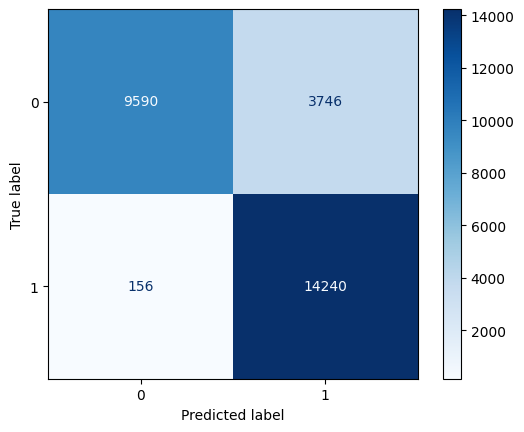

In [17]:
cm = confusion_matrix(y_train, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Resultados

In [18]:
print("Reporte de Clasificación basado en probabilidades:")
print(classification_report(y_train, y_pred))


# Mostrar resultados
print(f"ROC AUC con el mejor modelo: {roc_auc}")
print(f"PR AUC con el mejor modelo: {pr_auc} \n " )  



# Mostrar resultados en el formato solicitado
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")




print(f"Recall (Sensibilidad): {recall:.4f}")
print(f"Specificity (Especificidad): {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

Reporte de Clasificación basado en probabilidades:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83     13336
           1       0.79      0.99      0.88     14396

    accuracy                           0.86     27732
   macro avg       0.89      0.85      0.86     27732
weighted avg       0.88      0.86      0.86     27732

ROC AUC con el mejor modelo: 0.8574375497226201
PR AUC con el mejor modelo: 0.8680780252568306 
 
Accuracy: 0.8593
Precision: 0.7917
Recall (Sensibilidad): 0.9892
Specificity (Especificidad): 0.7191
F1-Score: 0.8795
ROC AUC: 0.8574
PR AUC: 0.8681


**Precision**

La precisión mide la proporción de predicciones positivas que son realmente correctas. Se centra en la exactitud de los verdaderos positivos entre todos los casos clasificados como positivos. 

Alta precisión indica pocos falsos positivos .
Ideal en casos donde los falsos positivos tienen un alto costo (por ejemplo, diagnósticos médicos donde un falso positivo puede generar tratamientos innecesarios).  la alta precision para este caso es de Precision: 0.7917





El modelo tiene un buen desempeño global, clasificando correctamente la mayoría de los casos (positivos y negativos).  El modelo tiene una precisión moderada, lo que significa que el 79.17% de las predicciones positivas son correctas. Un PR AUC elevado refuerza que el modelo es efectivo para manejar datos desequilibrados

**Recall o Sensibilidad**

La exhaustividad mide la capacidad del modelo para identificar correctamente los casos positivos. Evalúa qué tan bien el modelo detecta los verdaderos positivos entre todos los casos que realmente son positivos. para este caso el recall fue de 0.9892
